## How to use the UniRep mLSTM "babbler". This version demonstrates the 64-unit and the 1900-unit architecture. 

We recommend getting started with the 64-unit architecture as it is easier and faster to run, but has the same interface as the 1900-unit one.

Use the 64-unit or the 1900-unit model?

In [1]:
USE_FULL_1900_DIM_MODEL = False # if True use 1900 dimensional model, else use 64 dimensional one.

## Setup

In [2]:
import tensorflow as tf
import numpy as np

# Set seeds
tf.set_random_seed(42)
np.random.seed(42)

if USE_FULL_1900_DIM_MODEL:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/1900_weights/ 1900_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler1900 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./1900_weights"
    
else:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/64_weights/ 64_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler64 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./64_weights"

## Data formatting and management

Initialize UniRep, also referred to as the "babbler" in our code. You need to provide the batch size you will use and the path to the weight directory.

In [3]:
batch_size = 256
b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


UniRep needs to receive data in the correct format, a (batch_size, max_seq_len) matrix with integer values, where the integers correspond to an amino acid label at that position, and the end of the sequence is padded with 0s until the max sequence length to form a non-ragged rectangular matrix. We provide a formatting function to translate a string of amino acids into a list of integers with the correct codex:

You could use your own data flow as long as you ensure that the data format is obeyed. Alternatively, you can use the data flow we've implemented for UniRep training, which happens in the tensorflow graph. It reads from a file of integer sequences, shuffles them around, collects them into groups of similar length (to minimize padding waste) and pads them to the max_length. Here's how to do that:

First, sequences need to be saved in the correct format. Suppose we have a new-line seperated file of amino acid sequences, `seqs.txt`, and we want to format them. Note that training is currently only publicly supported for amino acid sequences less than 275 amino acids as gradient updates for sequences longer than that start to get unwieldy. If you want to train on sequences longer than this, please reach out to us. 

Sequence formatting can be done as follows:

In [4]:
# Load jackhmmer evotune seqs.
seqlens = []
with open("evotune_seqs/wide_jackhmmer_3_train.txt", "r") as source:
    with open("formatted_evotune_jackhmmer_train.txt", "w") as destination:
        for i,seq in enumerate(source):
            seq = seq.strip()
            if b.is_valid_seq(seq): 
                seqlens.append(len(seq))
                formatted = ",".join(map(str,b.format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')
print('Formatted %d sequences.' % len(seqlens))

Formatted 25781 sequences.


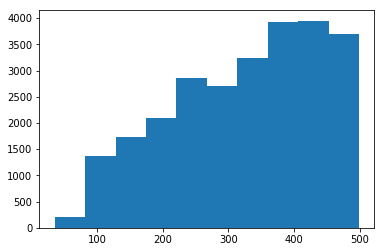

In [5]:
import matplotlib.pyplot as plt
plt.hist(seqlens)
plt.show()

This is what the integer format looks like

In [6]:
!head -n1 formatted_evotune_jackhmmer_train.txt

24,9,7,7,4,2,4,10,3,17,11,3,17,14,13,11,13,4,16,19,13,4,8,7,3,21,4,15,3,21,2,20,3,7,13,6,2,14,18,16,11,9,20,21,18,11,13,4,7,18,8,2,7,5,6,21,10,2,3,21,2,8,3,8,13,6,4,2,18,15,11,10,6,11,13,4,2,18,1,2,7,5,3,21,7,4,3,16,4,8,3,5,13,4,2,8,16


Notice that by default format_seq does not include the stop symbol (25) at the end of the sequence. This is the correct behavior if you are trying to train a top model, but not if you are training UniRep representations.

Now we can use a custom function to bucket, batch and pad sequences from `formatted.txt` (which has the correct integer codex after calling `babbler.format_seq()`). The bucketing occurs in the graph. 

What is bucketing? Specify a lower and upper bound, and interval. All sequences less than lower or greater than upper will be batched together. The interval defines the "sides" of buckets between these bounds. Don't pick a small interval for a small dataset because the function will just repeat a sequence if there are not enough to
fill a batch. All batches are the size you passed when initializing the babbler.

This is also doing a few other things:
- Shuffling the sequences by randomly sampling from a 10000 sequence buffer
- Automatically padding the sequences with zeros so the returned batch is a perfect rectangle
- Automatically repeating the dataset

In [7]:
bucket_op = b.bucket_batch_pad("formatted_evotune_jackhmmer_train.txt", lower=100, upper=500, interval=50)

Inconveniently, this does not make it easy for a value to be associated with each sequence and not lost during shuffling. You can get around this by just prepending every integer sequence with the sequence label (eg, every sequence would be saved to the file as "{brightness value}, 24, 1, 5,..." and then you could just index out the first column after calling the `bucket_op`. Please reach out if you have questions on how to do this.

Now that we have the `bucket_op`, we can simply `sess.run()` it to get a correctly formatted batch

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch = sess.run(bucket_op)
    
print(batch)
print(batch.shape)

[[24  1 15 ...  0  0  0]
 [24  1 21 ...  0  0  0]
 [24  1 18 ...  9 17  0]
 ...
 [24  5  6 ...  0  0  0]
 [24  1 14 ...  0  0  0]
 [24  1 18 ...  0  0  0]]
(256, 449)


You can look back and see that the batch_size we passed to __init__ is indeed 12, and the second dimension must be the longest sequence included in this batch. Now we have the data flow setup (note that as long as your batch looks like this, you don't need my flow), so we can proceed to implementing the graph. The module returns all the operations needed to feed in sequence and get out trainable representations.

## Training the LSTM with evotuning sequences

First, obtain all of the ops needed to output a representation

In [9]:
final_hidden, x_placeholder, batch_size_placeholder, seq_length_placeholder, initial_state_placeholder = (
    b.get_rep_ops())
logits, seqloss, x_placeholder, y_placeholder, batch_size_placeholder, initial_state_placeholder = (
    b.get_babbler_ops())

`final_hidden` should be a batch_size x rep_dim matrix.

Lets say we want to train a basic feed-forward network as the top model, doing regression with MSE loss, and the Adam optimizer. We can do that by:

1.  Defining a loss function.

2.  Defining an optimizer that's only optimizing variables in the top model.

3.  Minimizing the loss inside of a TensorFlow session

In [10]:
learning_rate=.001
optimizer = tf.train.AdamOptimizer(learning_rate)
tuning_op = optimizer.minimize(seqloss)

We next need to define a function that allows us to calculate the length each sequence in the batch so that we know what index to use to obtain the right "final" hidden state

In [11]:
def nonpad_len(batch):
    nonzero = batch > 0
    lengths = np.sum(nonzero, axis=1)
    return lengths

We are ready to train. As an illustration, let's learn to predict the number 42 just optimizing the top model.

In [ ]:
num_iters = 50
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_iters):
        batch = sess.run(bucket_op)
        loss_, __, = sess.run([seqloss, tuning_op],
                feed_dict={
                     x_placeholder: batch,
                     y_placeholder: batch,
                     batch_size_placeholder: batch_size,
                     initial_state_placeholder:b._zero_state
                }
        )         
        print("Iteration {0}: {1}".format(i, loss_))
    if i % 10 == 0:
        b.dump_weights(sess, dir_name="./64_evotuned_weights")

Iteration 0: 3.4386937618255615
Iteration 1: 2.8579554557800293
Iteration 2: 2.7213168144226074
Iteration 3: 2.6177334785461426
Iteration 4: 2.448274612426758
Iteration 5: 2.202867031097412
Iteration 6: 2.0735440254211426
Iteration 7: 1.8359992504119873
Iteration 8: 1.686475396156311
Iteration 9: 1.5292823314666748
Iteration 10: 1.5034160614013672
Iteration 11: 1.3086838722229004
Iteration 12: 1.2056422233581543
Iteration 13: 1.1270161867141724
Iteration 14: 1.0138614177703857
Iteration 15: 0.9373990297317505
